# Pan01 Sea Ice Volume

In [1]:
import glob
import dask.distributed as dsk
import xesmf as xe
from pathlib import Path
import numpy as np
import xarray as xr

import xgcm
import cf_xarray

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean as cm
import pyproj
import cartopy.feature as cft
import glob

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36459,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35223,Total threads: 1
Dashboard: /proxy/46177/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:34977,


In [3]:
# Importing data

pathsC = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ice_month.nc'))
pathsM = np.sort(glob.glob('/scratch/x77/jn8053/mom6/archive/panant-01-zstar-ssp126-prsc-rest/*/*.ice_month.nc'))

In [4]:
# Time variant variables
def preprocess(ds):
    ds = ds['sithick']
    return ds

cont = xr.open_mfdataset(pathsC, preprocess = preprocess, chunks = 'auto')
melt = xr.open_mfdataset(pathsM, preprocess = preprocess, chunks = 'auto')

In [5]:
cont = cont.sel(time=slice('2001-01-01','2010-12-31'))
melt = melt.sel(time=slice('2001-01-01','2010-12-31'))

In [6]:
cont = cont.rename({'xT': 'xh', 'yT': 'yh'})
melt = melt.rename({'xT': 'xh', 'yT': 'yh'})

In [7]:
cont

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 120, yh: 845, xh: 3600)
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Data variables:
    sithick  (time, yh, xh) float32 1GB dask.array<chunksize=(2, 845, 3600), meta=np.ndarray>

In [8]:
# Import area
area_old = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_static.nc')['areacello']
var = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_month_z.nc')['so']
area_corr = area_old*(var.isel(time=0,z_l=0)*0 +1)

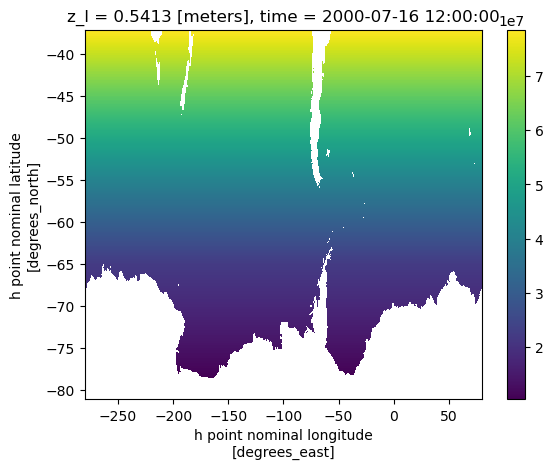

In [10]:
area_corr.plot()

In [11]:
siv_C = cont['sithick'] * area_corr
siv_M = melt['sithick'] * area_corr

# Map

In [12]:
siv_map_C = siv_C.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')
siv_map_M = siv_M.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')

In [13]:
siv_map_anom = siv_map_M - siv_map_C
siv_map_anom

<xarray.DataArray (yh: 845, xh: 3600)> Size: 12MB
dask.array<sub, shape=(845, 3600), dtype=float32, chunksize=(845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
    z_l      float64 8B 0.5413

In [14]:
siv_map_anom = siv_map_anom.load()

In [15]:
## Creating shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [16]:
depth = xr.open_dataset('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output050/20050501.ocean_static.nc')['deptho']
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [23]:
siv_map_anom.max().load()

<xarray.DataArray ()> Size: 8B
array(2242116.)
Coordinates:
    z_l      float64 8B 0.5413

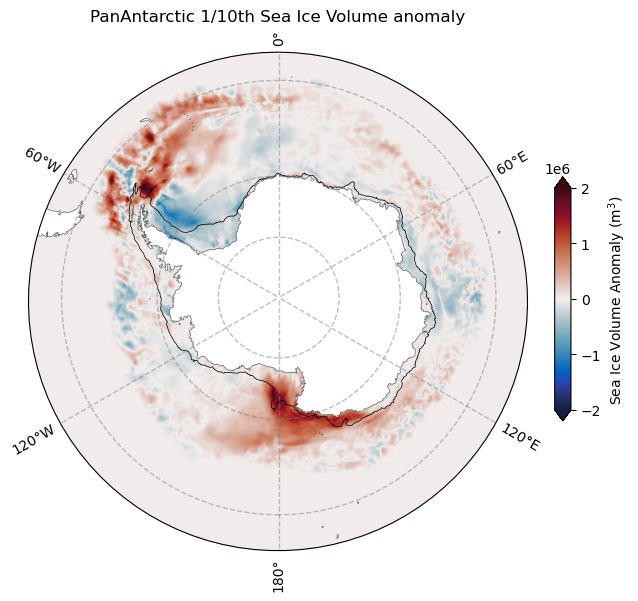

In [29]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -50], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

siv_map_anom.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-2000000,
    vmax=2000000,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Sea Ice Volume Anomaly (m$^{3}$)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAntarctic 1/10th Sea Ice Volume anomaly");

# Time series

In [25]:
cont_shelf = siv_C.where(shelf_mask == 1)
melt_shelf = siv_M.where(shelf_mask == 1)

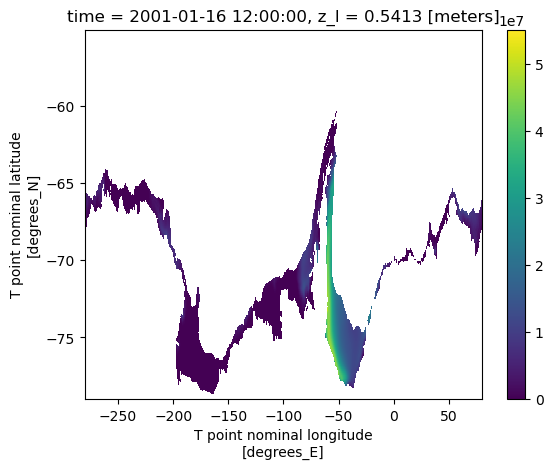

In [26]:
cont_shelf.isel(time=0).plot()

In [27]:
# Spatial average
siv_time_C = (area_corr * cont_shelf).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])
siv_time_M = (area_corr * melt_shelf).sum(['xh', 'yh']) / area_corr.where(shelf_mask == 1).sum(['xh', 'yh'])

In [28]:
siv_time_C

<xarray.DataArray (time: 120)> Size: 480B
dask.array<truediv, shape=(120,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    z_l      float64 8B 0.5413
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00

In [31]:
siv_time_C = siv_time_C.load()
siv_time_M = siv_time_M.load()

Text(0.5, 1.0, 'Sea Ice Volume Pan01 prescribed')

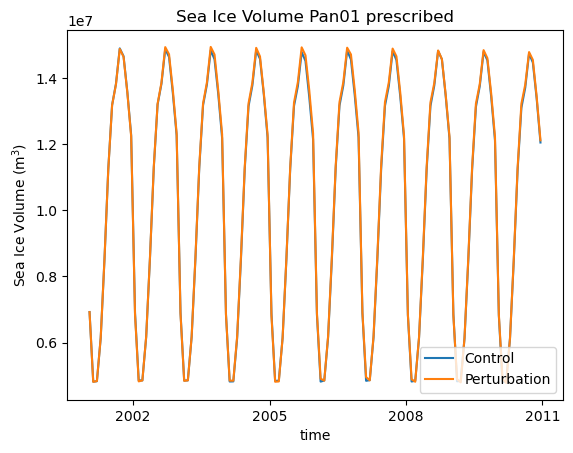

In [32]:
siv_time_C.plot(label = 'Control')
siv_time_M.plot(label = 'Perturbation')

plt.legend(loc='lower right')
plt.ylabel('Sea Ice Volume (m$^{3}$)');
plt.title('Sea Ice Volume Pan01 prescribed')

In [35]:
# Regular anomaly
siv_time_anom = siv_time_M - siv_time_C
siv_time_anom = siv_time_anom.load()

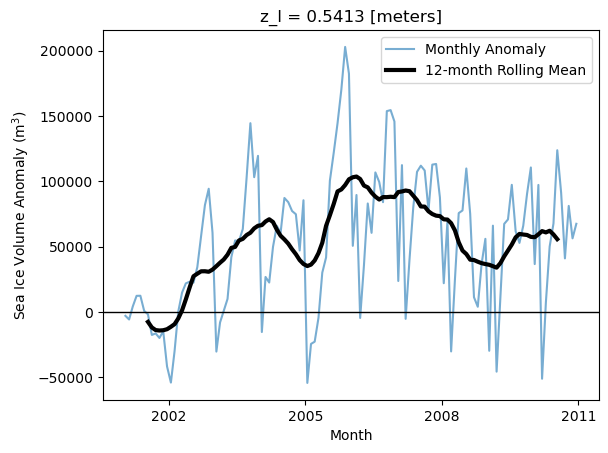

In [46]:
# Plot original anomaly
siv_time_anom.plot(label='Monthly Anomaly', alpha=0.6)

# Add rolling mean (12-month window)
siv_time_anom.rolling(time=12, center=True).mean().plot(
    label='12-month Rolling Mean', linewidth=3, color='black'
)

plt.ylabel('Sea Ice Volume Anomaly (m$^{3}$)')
plt.xlabel('Month')
plt.legend()
plt.axhline(0, color='k', linewidth=1, linestyle='-')
#plt.grid(True)

Text(0, 0.5, 'Sea Ice Volume (m$^{3}$)')

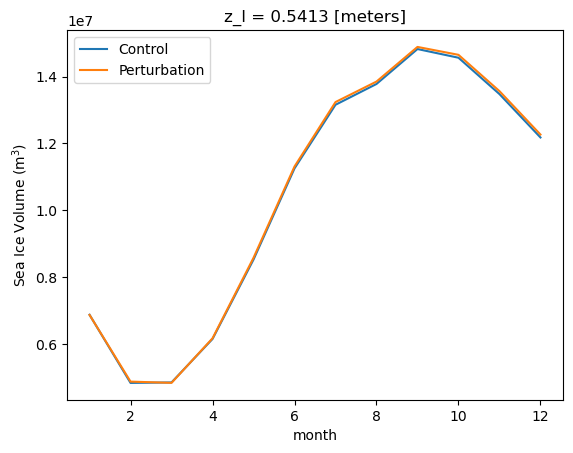

In [33]:
siv_time_C.groupby('time.month').mean('time').plot(label='Control')
siv_time_M.groupby('time.month').mean('time').plot(label='Perturbation')

plt.legend()
plt.ylabel('Sea Ice Volume (m$^{3}$)')

Text(0.5, 0, 'Month')

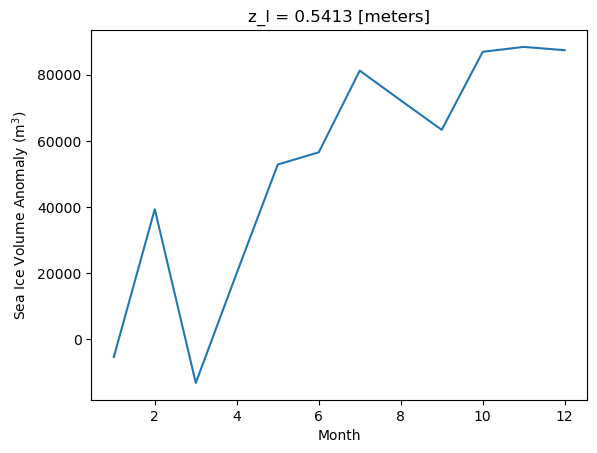

In [34]:
seasonal_anom = (siv_time_M.groupby('time.month').mean('time') - siv_time_C.groupby('time.month').mean('time'))
seasonal_anom.plot()

plt.ylabel('Sea Ice Volume Anomaly (m$^{3}$)')
plt.xlabel('Month')

In [47]:
# Save data
siv_map_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_map_cont_prescribed_Pan01.nc')
siv_map_M.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_map_melt_prescribed_Pan01.nc')
siv_map_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_map_anom_prescribed_Pan01.nc')


In [48]:
siv_time_C.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_time_C_prescribed_Pan01.nc')
siv_time_M.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_time_M_prescribed_Pan01.nc')
siv_time_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_time_anom_prescribed_Pan01.nc')
seasonal_anom.to_netcdf('/g/data/g40/kc5856/thesis_figures/data_files/ice_volume_seasonal_time_anom_prescribed_Pan01.nc')